In [1]:
import pandas as pd
import seaborn as sns
import cv2
import numpy as np

from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

import tensorflow as tf
# import tensorflow.compat.v1 as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
import os, sys, time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from collections import OrderedDict
# from tensorflow.python.ops import math_ops
# import tensorflow.keras.backend as kb
from tensorflow_addons.utils.ensure_tf_install import _check_tf_version
_check_tf_version()
from tensorflow_addons import losses

# Custom Functions
# Added to path by using sys.path.append('')
sys.path.append('/home/akanu/git/anomalous_pred/custom_functions')
from load_data import Files_Load, Boxes, test_split_norm_abnorm, norm_train_max_min
from custom_metrics import bb_intersection_over_union, bb_intersection_over_union_np
from coordinate_change import xywh_tlbr, tlbr_xywh
from pedsort import pedsort

# Kmeans
from sklearn.cluster import KMeans

# Need to figue out why this is not working
# from persistence1d import RunPersistence


from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [14]:
plt.style.use('classic')

# GPU Check

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  2


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
#   try:
#     tf.config.experimental.set_virtual_device_configuration(
#         gpus[1],
#         [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5500)])
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Virtual devices must be set before GPUs have been initialized
#     print(e)

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 2 Logical GPUs


# Load Data

In [6]:
frames = 20
# startvid=0
# endvid=21

train_file = "/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_tlbr/Txt_Data/Train_Box/"
test_file = "/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_tlbr/Txt_Data/Test_Box/"

loc_files_train, loc_files_test, box_train_txt, box_test_txt = Files_Load(train_file, test_file)

# Don't forget to change to xywh 
traindict = Boxes(loc_files_train, box_train_txt, frames, pad ='pre', to_xywh=True)
testdict = Boxes(loc_files_test, box_test_txt, frames, pad ='pre', to_xywh = True)
abnormal_dict, normal_dict = test_split_norm_abnorm(testdict) #splits by which predicted frames are normal or not

# Normilize data
max1 = traindict['x_ppl_box'].max()
min1 = traindict['x_ppl_box'].min()
xx,yy = norm_train_max_min(data_dict = traindict, max1=max1,min1=min1)
xx_norm,yy_norm = norm_train_max_min(data_dict = normal_dict, max1=max1,min1=min1)
xx_abnorm,yy_abnorm = norm_train_max_min(data_dict = abnormal_dict, max1=max1,min1=min1)


In [17]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32
xx_train, xx_val,yy_train,yy_val = train_test_split(xx,yy, test_size = 0.3)
train_univariate = tf.data.Dataset.from_tensor_slices((xx_train,yy_train))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_univariate = tf.data.Dataset.from_tensor_slices((xx_val,yy_val))
val_univariate = val_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Pedestrain

# Video Results

In [18]:
None

# Train Model

In [19]:
print(sys.path)

['/home/akanu/git/anomalous_pred/model', '', '/opt/ros/melodic/lib/python2.7/dist-packages', '/home/akanu/.virtualenvs/anomalous_pred/lib/python36.zip', '/home/akanu/.virtualenvs/anomalous_pred/lib/python3.6', '/home/akanu/.virtualenvs/anomalous_pred/lib/python3.6/lib-dynload', '/usr/lib/python3.6', '/home/akanu/.virtualenvs/anomalous_pred/lib/python3.6/site-packages', '/home/akanu/.virtualenvs/anomalous_pred/lib/python3.6/site-packages/IPython/extensions', '/tmp/tmpin9xv2si', '/home/akanu/git/anomalous_pred/custom_functions']


In [20]:
sys.path.insert(0,'/home/akanu/git/anomalous_pred/model')
from lstm_models import lstm_xywh_avenue_20


In [21]:
model_loc = '/home/akanu/git/anomalous_pred/saved_models'
name_conv=['lstm', 'xywh', 'avenue', frames]

In [22]:

lstm_20 = lstm_xywh_avenue_20(train_data = train_univariate,
                              val_data = val_univariate,
                              model_loc = model_loc,
                              nc=name_conv,
                              epochs=300)


Epoch 1/300
3031/3031 [==============================] - 74s 24ms/step - loss: 0.0675 - val_loss: 0.0422
Epoch 2/300
3031/3031 [==============================] - 73s 24ms/step - loss: 0.0275 - val_loss: 0.0171
Epoch 3/300
3031/3031 [==============================] - 73s 24ms/step - loss: 0.0123 - val_loss: 0.0096
Epoch 4/300
3031/3031 [==============================] - 73s 24ms/step - loss: 0.0089 - val_loss: 0.0084
Epoch 5/300
3031/3031 [==============================] - 73s 24ms/step - loss: 0.0070 - val_loss: 0.0045
Epoch 6/300
3031/3031 [==============================] - 73s 24ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 7/300
3031/3031 [==============================] - 73s 24ms/step - loss: 8.5775e-04 - val_loss: 6.9205e-04
Epoch 8/300
3031/3031 [==============================] - 73s 24ms/step - loss: 6.0261e-04 - val_loss: 5.4435e-04
Epoch 9/300
3031/3031 [==============================] - 73s 24ms/step - loss: 5.0766e-04 - val_loss: 4.8710e-04
Epoch 10/300
3031/3031 [=======

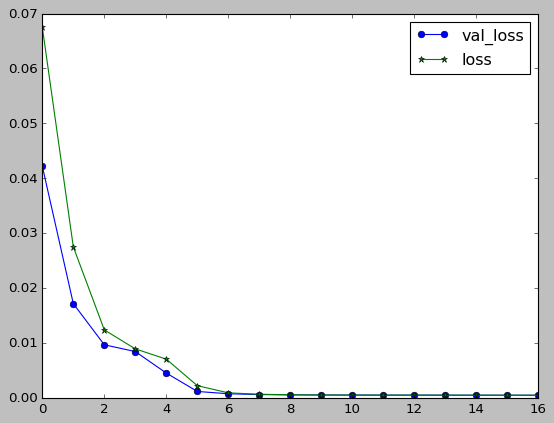

In [23]:
plt.plot(lstm_20.history['val_loss'],'-o',label='val_loss')
plt.plot(lstm_20.history['loss'], '-*', label='loss')
plt.legend()

# Load Model (If model is trained)

In [ ]:
model = tf.keras.models.load_model('lstm_5_xywh.h5', custom_objects = {'loss':'mse'} , compile=True)
lstm_20 = model
# Appears because of my custom loss fuction I could use evaluate

In [ ]:
# lstm_20.evaluate(xx,yy)

# Check IOU for video files

In [ ]:
# should make a for loop to evalute the table data

# Plot Data

In [ ]:
pic_loc = "/home/akanu/git/anomalous_pred/resulting_images/xywh/test_abnorm/{}_{}_{}"
visual_ouput(model=lstm_20,max1 = max1, min1=min1, vid=1,pic_loc =pic_loc, output_dict=abnormal_dict,xywh = True)

In [ ]:
pic_loc = "/home/akanu/git/anomalous_pred/resulting_images/xywh/test_norm/{}_{}_{}"
visual_ouput(model=lstm_20,max1 = max1, min1=min1, vid=1,pic_loc =pic_loc, output_dict=normal_dict,xywh = True)

# Sorting data

In [ ]:
j ='1'
ped = pedsort(testdict)
x,y = norm_train_max_min(data_dict=ped[j], max1 = max1, min1=min1 )

In [ ]:
out1 = lstm_20.predict(x)


out = bb_intersection_over_union_np(xywh_tlbr(out1), xywh_tlbr(y))
plt.plot(ped[j]['frame_ppl_id'][:,-1,0], np.squeeze(out),'-')
plt.plot(ped[j]['frame_ppl_id'][:,-1,0], ped[j]['abnormal'])
plt.xlabel('Frame')
plt.ylabel('IOU')
print(np.mean(out))
# sns.distplot(np.squeeze(out))

In [ ]:
out1.shape

# Using averaged iou to find Abnormal vs normal
## Doesn't work well

In [ ]:
# Tries to find normal/abnormal pedestrian from averaged iou
iou_sum = []
for j in ped.keys():
#     print(j)
    x,y = norm_train_max_min(data_dict=ped[j], max1 = max1, min1=min1 )
    out1 = lstm_20.predict(x)
    out = bb_intersection_over_union_np(xywh_tlbr(out1),xywh_tlbr(y))
#     print(out.shape)
    iou_sum.append([np.mean(out), np.any(ped[j]['abnormal']) ])
iou_sum = np.array(iou_sum)

In [ ]:
abnormal_ped = iou_sum[np.nonzero(iou_sum[:,1])]

In [ ]:
norm_ped = iou_sum[np.where(iou_sum[:,1]==0)]

In [ ]:

plt.plot(norm_ped[:,0],'-*', label='normal')
plt.plot(abnormal_ped[:,0], '-+', label='abnormal')
plt.xlabel('pedestrian')
plt.ylabel('Averaged IOU over time')
plt.legend()
# sns.distplot(norm_ped[:,0])
# sns.distplot(abnormal_ped[:,0])

# Finding distribution of normal vs abnormal pedestrains

In [ ]:
iou_abnorm = []
iou_norm = []
for j in ped.keys():
#     print(j)
    x,y = norm_train_max_min(data_dict=ped[j], max1 = max1, min1=min1 )
    out1 = lstm_20.predict(x)
    out = bb_intersection_over_union_np(xywh_tlbr(out1),xywh_tlbr(y))
#     print(out.shape)
    if np.any(ped[j]['abnormal']):
#         iou_abnorm.append(np.squeeze(out).tolist()[:])
        iou_abnorm += np.squeeze(out).tolist()
    else:
#         iou_norm.append(np.squeeze(out).tolist())
        iou_norm += np.squeeze(out).tolist()

# iou_abnorm = np.array(iou_abnorm)
# iou_norm = np.array(iou_norm)


In [ ]:
plt.style.use('classic')


In [ ]:
sns.distplot(iou_abnorm, label='abnormal pedestrain')
sns.distplot(iou_norm, label='normal pedestrain')
plt.title('Test Video 1')
plt.legend()

In [ ]:
len(testdict['abnormal'])

# Finding distrubtions of Normal vs abnormal frames

In [ ]:
startvid =0
endvid=21

testdict = Boxes(loc_files_test[startvid:endvid], box_test_txt[startvid:endvid], frames, pad ='pre', to_xywh = True)

In [ ]:
x,y = norm_train_max_min(data_dict=testdict, max1 = max1, min1=min1 )
out1 = lstm_20.predict(x)
out = bb_intersection_over_union_np(xywh_tlbr(out1),xywh_tlbr(y))
out = np.squeeze(out)
#     print(out.shape)
norm_index = np.where(testdict['abnormal']== 0)
abnorm_index = np.where(testdict['abnormal']== 1)


In [ ]:
len(abnorm_index[0])

In [ ]:
sns.distplot(out[abnorm_index], label='abnormal frames')
sns.distplot(out[norm_index], label='normal frames')
plt.title('All Test Video ')
plt.legend()

# Binary Classification on frames

In [ ]:
x,y = norm_train_max_min(data_dict=testdict, max1 = max1, min1=min1 )
out1 = lstm_20.predict(x)
out = bb_intersection_over_union_np(xywh_tlbr(out1),xywh_tlbr(y))
out = np.squeeze(out)
np.random.seed(49)
rand = np.random.permutation(len(out))


In [ ]:
def create_baseline():
    with tf.device('/device:GPU:0'):
        # create model
        model = keras.Sequential()
        model.add(keras.layers.Dense(1, input_dim=1, activation='relu'))
        model.add(keras.layers.Dense(1, activation='sigmoid'))
        # Compile model
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

In [ ]:
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=32, verbose=0)

In [ ]:
kfold = StratifiedKFold(n_splits=10, shuffle=True)


In [ ]:
results = cross_val_score(estimator, out[rand], testdict['abnormal'][rand], cv=kfold)

In [ ]:
print("Baseline: %.2f%% (%.8f%%)" % (results.mean()*100, results.std()*100))

# Binary classifcation Even Split

In [ ]:
startvid =0
endvid=21

testdict = Boxes(loc_files_test[startvid:endvid], box_test_txt[startvid:endvid], frames, pad ='pre', to_xywh = True)


In [ ]:
x,y = norm_train_max_min(data_dict=testdict, max1 = max1, min1=min1 )
out1 = lstm_20.predict(x)
out = bb_intersection_over_union_np(xywh_tlbr(out1),xywh_tlbr(y))
out = np.squeeze(out)
np.random.seed(49)
rand = np.random.permutation(len(out))

In [ ]:
abnorm_index = np.where(testdict['abnormal']==1)
norm_index = np.where(testdict['abnormal'] == 0)

In [ ]:
print('abnormal: {}, normal: {}'.format(len(abnorm_index[0]), len(norm_index[0])))
# Want to create a function that allows me to vary the amount of abnormalites in the trainingg loader
# Want to also be able to vary amount of norms in training loader
# Need to keep track of indexes so that I can assign correct ones to abnormal truth

In [ ]:
weight_scale = 1

In [ ]:
# def vary_abnormal_normal_frames():
    abnorm_index = np.where(testdict['abnormal']==1)
    norm_index = np.where(testdict['abnormal'] == 0)
    abnormal_split = 0.5
    val_split = 0.3
    
    ratio = int(len(abnorm_index[0])*abnormal_split)
    a = abnorm_index[0][:ratio]
    b = norm_index[0][:ratio*weight_scale]
    
    val_ratio = int(val_split*len(a) )
    
    val_a = a[:val_ratio]
    val_b = b[:val_ratio*weight_scale]
    
    test_a = a[val_ratio:]
    test_b = b[val_ratio*weight_scale:]
    
    c = abnorm_index[0][ratio:]
    d = norm_index[0][ratio*weight_scale:]
    
    index = [a,b,c,d]
#     train  = {}
#     test = {}
#     for i in index[:2]:
#         x = out[i]
#         y = testdict['abnormal'][ i]
#         data.append
        
#     for i in index[2:]:
#         x = out[i]
#         y = testdict['abnormal'][ i]
#         data.append
        
    
    
    train_x_an = out[ test_a]
    train_y_an= testdict['abnormal'][ test_a ]
    
    train_x_n = out[ test_b]
    train_y_n = testdict['abnormal'][ test_b ]
    
    train_x = np.append(train_x_an,train_x_n,axis =0)
    train_y = np.append(train_y_an,train_y_n, axis = 0 )
    
    
    val_x_an = out[ val_a]
    val_y_an= testdict['abnormal'][ val_a ]
    
    val_x_n = out[ val_b]
    val_y_n = testdict['abnormal'][ val_b ]
    
    val_x = np.append(val_x_an,val_x_n,axis =0)
    val_y = np.append(val_y_an,val_y_n, axis = 0 )
       
    
    
    
    test_x_an = out[ c ]
    test_y_an= testdict['abnormal'][ c]
    
    test_x_n = out[ d ] 
    test_y_n = testdict['abnormal'][ d ]
    
    test_x = np.append(test_x_an, test_x_n, axis = 0)
    test_y = np.append(test_y_an, test_y_n, axis = 0)

    

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32
train_univariate_1 = tf.data.Dataset.from_tensor_slices((train_x,train_y))
train_univariate_1 = train_univariate_1.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_univariate_1 = tf.data.Dataset.from_tensor_slices((val_x,val_y))
val_univariate_1 = val_univariate_1.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def create_baseline():
    with tf.device('/device:GPU:0'):
        # create model
        neurons = 20
        dropout_ratio = 0.3
        model = keras.Sequential()
        model.add(keras.layers.Dense(neurons, input_dim=1, activation='relu'))
        model.add(keras.layers.Dense(neurons, input_dim=1, activation='relu'))
        model.add(keras.layers.Dropout(dropout_ratio))
        model.add(keras.layers.Dense(neurons, input_dim=1, activation='relu'))
        model.add(keras.layers.Dense(neurons, input_dim=1, activation='relu'))
        model.add(keras.layers.Dropout(dropout_ratio))
        model.add(keras.layers.Dense(1, activation='sigmoid'))
        # Compile model
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

In [ ]:
# np.random.seed(49)
# rand = np.random.permutation(len(out))
# size = 115624
# test ={}

# for i in testdict.keys():
#     testdict[i] = testdict[i][rand]

In [ ]:
binary_model = create_baseline()

In [ ]:
binary_model.summary()

In [ ]:
# x_train,x_test,y_train, y_test =train_test_split(out[rand], testdict['abnormal'][rand],shuffle=False,test_size=.5)
# Bad thing is can't guantree how many samples of abnormal is in x_train,x_test

In [ ]:
# x_train,x_test,y_train, y_test =train_test_split(out, testdict['abnormal'],shuffle=False,test_size=.9)


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0005, 
                                                  patience=10, restore_best_weights=True)

In [ ]:
bm = binary_model.fit(train_univariate_1, validation_data=val_univariate_1, epochs=300,callbacks=early_stopping)

In [ ]:
plt.plot(bm.history['val_loss'], label='val_loss')
plt.plot(bm.history['loss'], label='loss')
plt.legend()



In [ ]:
bm.history.keys()

In [ ]:
plt.plot(bm.history['val_accuracy'], label='val_acc')
plt.plot(bm.history['accuracy'], label='acc')
plt.legend()

In [ ]:
y_pred = binary_model.predict(test_x)
plt.plot(y_pred, '*')

In [ ]:
y_pred = binary_model.predict(test_x) > 0.5
tf.math.confusion_matrix(test_y,y_pred , num_classes = 2)

Their does not seem to be a need to create a custom loss.
Reason is that weihted_cross_entropy_with_logits exists

# Weighted loss

In [ ]:
startvid =0
endvid=21

testdict = Boxes(loc_files_test[startvid:endvid], box_test_txt[startvid:endvid], frames, pad ='pre', to_xywh = True)


In [ ]:
weight_scale = 10

In [ ]:
x,y = norm_train_max_min(data_dict=testdict, max1 = max1, min1=min1 )
out1 = lstm_20.predict(x)
out = bb_intersection_over_union_np(xywh_tlbr(out1),xywh_tlbr(y))
out = np.squeeze(out)
np.random.seed(49)
rand = np.random.permutation(len(out))

In [ ]:
# def vary_abnormal_normal_frames():
    abnorm_index = np.where(testdict['abnormal']==1)
    norm_index = np.where(testdict['abnormal'] == 0)
#     rand_an = np.random.permutation(len(abnorm_index[0]))
    abnormal_split = 0.9
    val_split = 0.2
    
    
    ratio = int(len(abnorm_index[0])*abnormal_split)
    a = abnorm_index[0][:ratio]
    b = norm_index[0][:ratio*weight_scale]
    
    initial_bias = np.log([ratio/(ratio*weight_scale)])

    
    val_ratio = int(val_split*len(a) )
    
    val_a = a[:val_ratio]
    val_b = b[:val_ratio*weight_scale]
    
    test_a = a[val_ratio:]
    test_b = b[val_ratio*weight_scale:]
    
    c = abnorm_index[0][ratio:]
    d = norm_index[0][ratio*weight_scale:]
    
    index = [a,b,c,d]
#     train  = {}
#     test = {}
#     for i in index[:2]:
#         x = out[i]
#         y = testdict['abnormal'][ i]
#         data.append
        
#     for i in index[2:]:
#         x = out[i]
#         y = testdict['abnormal'][ i]
#         data.append
        
    
    
    train_x_an = out[ test_a]
    train_y_an= testdict['abnormal'][ test_a ]
    
    train_x_n = out[ test_b]
    train_y_n = testdict['abnormal'][ test_b ]
    
    train_x = np.append(train_x_an,train_x_n,axis =0)
    train_y = np.append(train_y_an,train_y_n, axis = 0 )
    
    
    val_x_an = out[ val_a]
    val_y_an= testdict['abnormal'][ val_a ]
    
    val_x_n = out[ val_b]
    val_y_n = testdict['abnormal'][ val_b ]
    
    val_x = np.append(val_x_an,val_x_n,axis =0)
    val_y = np.append(val_y_an,val_y_n, axis = 0 )
       
    
    
    
    test_x_an = out[ c ]
    test_y_an= testdict['abnormal'][ c]
    
    test_x_n = out[ d ] 
    test_y_n = testdict['abnormal'][ d ]
    
    test_x = np.append(test_x_an, test_x_n, axis = 0)
    test_y = np.append(test_y_an, test_y_n, axis = 0)
    
#     return 
   

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32
train_univariate = tf.data.Dataset.from_tensor_slices((train_x,train_y))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_univariate = tf.data.Dataset.from_tensor_slices((val_x,val_y))
val_univariate = val_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
initial_bias = np.log([ratio/(ratio*weight_scale)])


In [ ]:
initial_bias

In [ ]:
print('training')
print('abnormal_mean: {}, normal_mean: {}'.format(train_x_an.mean(), train_x_n.mean()))
print('abnormal_mean: {}, normal_mean: {}'.format(train_y_an.mean(), train_y_n.mean()))
print("\n")

print('testing')
print('abnormal_mean: {}, normal_mean: {}'.format(test_x_an.mean(), test_x_n.mean()))
print('abnormal_mean: {}, normal_mean: {}'.format(test_y_an.mean(), test_y_n.mean()))

In [ ]:
def weighted_binary(y,x):
    return tf.nn.weighted_cross_entropy_with_logits(y,x,pos_weight = weight_scale)

In [ ]:
x = tf.constant([.8], dtype=tf.float32)

In [ ]:
y = tf.constant([1], dtype=tf.float32)

In [ ]:
 tf.nn.weighted_cross_entropy_with_logits(y,x,pos_weight = 1)

In [ ]:
tf.keras.losses.binary_crossentropy(y, x, from_logits=True)

In [ ]:
def create_baseline_weighted(output_bias = None):
    with tf.device('/device:GPU:0'):
        # create model
        if output_bias is not None:
            output_bias = keras.initializers.Constant(output_bias)
        neurons = 30
        dropout_ratio = 0.3
        model = keras.Sequential()
        model.add(keras.layers.Dense(neurons, input_dim=1, activation='relu'))
        model.add(keras.layers.Dense(neurons, activation='relu'))
        model.add(keras.layers.Dropout(dropout_ratio))
        model.add(keras.layers.Dense(neurons, input_dim=1, activation='relu'))
        model.add(keras.layers.Dense(neurons, input_dim=1, activation='relu'))
        model.add(keras.layers.Dropout(dropout_ratio))
        model.add(keras.layers.Dense(1, bias_initializer=output_bias))
        # Compile model
#         wce = tf.nn.weighted_cross_entropy_with_logits(pos_weight = 10)
        model.compile(loss=weighted_binary, optimizer='adam', metrics=['accuracy'])
        return model

In [ ]:
model_wl = create_baseline_weighted(output_bias = initial_bias )

In [ ]:
model_wl.summary()

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0005, 
                                                  patience=10, restore_best_weights=True)

In [ ]:
model_wl.predict(test_x).min()

In [ ]:
wbm = model_wl.fit(train_univariate, validation_data=val_univariate, epochs=300,callbacks = early_stopping)

In [ ]:
plt.plot(wbm.history['loss'], '-*',label='loss')
plt.plot(wbm.history['val_loss'], '-o',label='val_loss')
plt.legend()


In [ ]:
plt.plot(wbm.history['accuracy'],'-*', label='acc')
plt.plot(wbm.history['val_accuracy'],'-*', label='val_acc')
plt.legend()

In [ ]:
wbm.history.keys()

In [ ]:
y_pred = model_wl.predict(test_x)
plt.plot(y_pred, '*')

In [ ]:
y_pred = model_wl.predict(test_x) >0.5
tf.math.confusion_matrix(test_y, y_pred, num_classes =2)

# XY difference

In [ ]:
x,y = norm_train_max_min(data_dict=testdict, max1 = max1, min1=min1 )
out = lstm_20.predict(x)
# np.random.seed(49)
# rand = np.random.permutation(len(out))

In [ ]:
xy_diff = []
for i in range(1,len(out)):
    
    xy_diff.append(out[i,:] - out[i-1,:])

xy_diff = np.array(xy_diff)
out =np.sum(np.square(xy_diff[:,0:2]), axis=1)
# out =np.sum(xy_diff[:,0:4], axis=1)
    

### 1)  XY difference from each other

In [ ]:
norm_index = np.where(testdict['abnormal'][1:]== 0)
abnorm_index = np.where(testdict['abnormal'][1:]== 1)

In [ ]:
sns.distplot(out[abnorm_index], label='abnormal frames')
sns.distplot(out[norm_index], label='normal frames')
plt.title('Test Video 1')
plt.legend()
plt.xlabel('XY Difference')
plt.ylabel('Frequency')

### 2) XY difference  predicted frame from ground truth

In [ ]:
x,y = norm_train_max_min(data_dict=testdict, max1 = max1, min1=min1 )
out = lstm_20.predict(x)

In [ ]:
xy_diff = []
for i in range(0,len(out)):
    
    xy_diff.append(out[i,:] - y[i,:])

xy_diff = np.array(xy_diff)
out =np.sum(np.square(xy_diff[:,0:4]), axis=1)

In [ ]:
norm_index = np.where(testdict['abnormal'][1:]== 0)
abnorm_index = np.where(testdict['abnormal'][1:]== 1)

In [ ]:
sns.distplot(out[abnorm_index], label='abnormal frames')
sns.distplot(out[norm_index], label='normal frames')
plt.title('Difference from GT Test Video 2')
plt.legend()
plt.xlabel('XY Difference')
plt.ylabel('Frequency')

In [ ]:
def create_baseline():
    with tf.device('/device:GPU:0'):
        # create model
        model = keras.Sequential()
        model.add(keras.layers.Dense(1, input_dim=1, activation='relu'))
        model.add(keras.layers.Dense(1, activation='sigmoid'))
        # Compile model
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

In [ ]:
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=32, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)


In [ ]:
results = cross_val_score(estimator, out[rand], testdict['abnormal'][rand], cv=kfold)

In [ ]:
plt.plot(ped[j]['frame_ppl_id'][1:,-1,0], out,'*')
# plt.plot(ped['1']['frame_ppl_id'][1:,-1,0], xy_diff[:,0],'-+')
# plt.plot(ped['1']['frame_ppl_id'][1:,-1,0], xy_diff[:,1],'-0')

In [ ]:
ped[j]['abnormal']

# Abnormal Through IOU

In [ ]:
j ='1'
out1 = lstm_20.predict(ped[j]['x_ppl_box'])
out = norm_train_max_min(data=out1, max1 = max1,min1 =min1,undo_norm=True)
bb_intersection_over_union(xywh_tlbr(out), xywh_tlbr(ped[j]['y_ppl_box']))

# K means Clustering Approach

https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1

In [ ]:
x,y = norm_train_max_min(data_dict=testdict, max1 = max1, min1=min1 )
out = lstm_20.predict(x)
# out = bb_intersection_over_union_np(xywh_tlbr(out1),xywh_tlbr(y))
# out = np.squeeze(out)
# np.random.seed(49)
# rand = np.random.permutation(len(out))

In [ ]:
# y_pred_scal = model.predict(xx_test)
# y_pred = norm_train_max_min(data=y_pred_scal, max1 = max1,min1 =min1,undo_norm=True)

In [ ]:
kmean_scal = KMeans(n_clusters=2)
kmean = KMeans(n_clusters=2)

In [ ]:
kmean_scal.fit(y_pred_scal[:,0:2])
kmean.fit(y_pred[:,0:2])

In [ ]:
out = kmean_scal.cluster_centers_
out

In [ ]:
out1 = kmean.cluster_centers_
out1

In [ ]:
traindict.keys()

In [ ]:
traindict['frame_ppl_id'][0:3].shape

In [ ]:
ped = pedsort(testdict)

In [ ]:
j='86'
x,y = norm_train_max_min(data_dict=ped[j], max1=max1, min1=min1 )

out1 = model.predict(x)
bb_intersection_over_union(out1,y)

In [ ]:

plt.scatter(y_pred_scal[:,0], y_pred_scal[:,1],s=1, c='b')
plt.scatter(out[0,0], out[0,1],s=200, c ='g', marker='s')
plt.scatter(out[1,0], out[1,1], s=200, c ='r', marker='s')

In [ ]:
plt.scatter(y_pred[:,0], y_pred[:,1],s=1, c='b')
plt.scatter(out1[0,0], out1[0,1],s=200, c ='g', marker='s')
plt.scatter(out1[1,0], out1[1,1], s=200, c ='r', marker='s')

Suggestion that x,y is not enough to create a hyoer parameter to seperate abnomaly and normal pedestrains. Makes sense because abnormal and normal pedestrains walk over the same spatial features. Trying to do it for all pedestrains 